In [33]:
import mysql.connector
from mysql.connector import errorcode
import config
import pandas as pd
import numpy as np

In [92]:
dbname = 'nba'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor(buffered = True)

In [3]:
select_statement = """SELECT * FROM nba.box_score;"""
cursor.execute(select_statement)
nba_data = cursor.fetchall()

In [8]:
nba_df = pd.DataFrame(nba_data)
field_names = [i[0] for i in cursor.description]
nba_df.columns = field_names

In [11]:
nba_df_played = nba_df[nba_df['MIN'].notnull()]

In [12]:
nba_df_played.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57287 entries, 3 to 67817
Data columns (total 34 columns):
GAME_ID              57287 non-null object
TEAM_ID              57287 non-null float64
TEAM_ABBREVIATION    57287 non-null object
TEAM_CITY            57287 non-null object
PLAYER_ID            57287 non-null float64
PLAYER_NAME          57287 non-null object
START_POSITION       57287 non-null object
COMMENT              57287 non-null object
MIN                  57287 non-null object
FGM                  57287 non-null float64
FGA                  57287 non-null float64
FG_PCT               57287 non-null float64
FG3M                 57287 non-null float64
FG3A                 57287 non-null float64
FG3_PCT              57287 non-null float64
FTM                  57287 non-null float64
FTA                  57287 non-null float64
FT_PCT               57287 non-null float64
OREB                 57287 non-null float64
DREB                 57287 non-null float64
REB               

In [14]:
set(nba_df_played['SEASON_ID'])

{'22017', '22018', '22019'}

In [18]:
set(nba_df_played['PLAYER_ID'])

{1713.0,
 1717.0,
 1891.0,
 1938.0,
 2037.0,
 2199.0,
 2200.0,
 2207.0,
 2210.0,
 2216.0,
 2225.0,
 2403.0,
 2544.0,
 2546.0,
 2548.0,
 2555.0,
 2561.0,
 2570.0,
 2585.0,
 2594.0,
 2617.0,
 2730.0,
 2731.0,
 2733.0,
 2734.0,
 2736.0,
 2738.0,
 2744.0,
 2746.0,
 2747.0,
 2749.0,
 2754.0,
 2772.0,
 2863.0,
 101106.0,
 101107.0,
 101108.0,
 101109.0,
 101112.0,
 101123.0,
 101127.0,
 101133.0,
 101139.0,
 101141.0,
 101150.0,
 101161.0,
 101162.0,
 101181.0,
 200746.0,
 200752.0,
 200755.0,
 200757.0,
 200765.0,
 200768.0,
 200782.0,
 200794.0,
 200826.0,
 201142.0,
 201143.0,
 201144.0,
 201145.0,
 201147.0,
 201148.0,
 201149.0,
 201152.0,
 201156.0,
 201158.0,
 201160.0,
 201162.0,
 201163.0,
 201166.0,
 201167.0,
 201177.0,
 201188.0,
 201196.0,
 201229.0,
 201281.0,
 201563.0,
 201565.0,
 201566.0,
 201567.0,
 201568.0,
 201569.0,
 201571.0,
 201572.0,
 201573.0,
 201577.0,
 201578.0,
 201580.0,
 201583.0,
 201584.0,
 201585.0,
 201586.0,
 201587.0,
 201588.0,
 201589.0,
 201596.0,
 

In [70]:
nba_df_played.shape

(57287, 34)

# Get Trailing Averages for Last 3 Games

In [37]:
# Get average from last trail_len
def get_trailing_avg(df, col_name, trail_len):
    new_col = col_name + '_TRAIL' + str(trail_len)
    df[new_col] = None
    for i in range(0, trail_len):
        df.at[i, new_col] = 'game' + str(i + 1)
    for index in range(trail_len, len(df)):
        df.at[index, new_col] = np.mean(df.loc[index-trail_len:index-1, col_name])

In [49]:
nba_df_played.shape

(57287, 34)

In [67]:
nba_trailing = []
for season in set(nba_df_played['SEASON_ID']):
    for player in set(nba_df_played['PLAYER_ID']):
        games_played = nba_df_played[(nba_df_played['PLAYER_ID'] == player) & 
                                     (nba_df_played['SEASON_ID'] == season)]
        games_played = games_played.sort_values(by = ['GAME_ID'])
        games_played.reset_index(drop = True, inplace = True)
                      
        # Group 1: Field Goals
        get_trailing_avg(games_played, 'FGM', 3)
        get_trailing_avg(games_played, 'FGA', 3)
        get_trailing_avg(games_played, 'FG_PCT', 3)
        
        # Group 2: Three-Pointers
        get_trailing_avg(games_played, 'FG3M', 3)
        get_trailing_avg(games_played, 'FG3A', 3)
        get_trailing_avg(games_played, 'FG3_PCT', 3)

        # Group 3: Free Throws
        get_trailing_avg(games_played, 'FTM', 3)
        get_trailing_avg(games_played, 'FTA', 3)
        get_trailing_avg(games_played, 'FT_PCT', 3)

        # Group 4: Rebounds
        get_trailing_avg(games_played, 'OREB', 3)
        get_trailing_avg(games_played, 'DREB', 3)
        get_trailing_avg(games_played, 'REB', 3)
        
        # Group 5: Miscellaneous
        get_trailing_avg(games_played, 'PTS', 3)
        get_trailing_avg(games_played, 'STL', 3)
        get_trailing_avg(games_played, 'AST', 3)            
        get_trailing_avg(games_played, 'BLK', 3)
        get_trailing_avg(games_played, 'TOS', 3)
        get_trailing_avg(games_played, 'doubles', 3)
                      
        nba_trailing.append(games_played)

In [68]:
nba_trailing_df = pd.concat(nba_trailing)

In [74]:
nba_trailing_played = nba_trailing_df[nba_trailing_df['MIN'].notnull()]

In [252]:
nba_trailing_played.shape

(57287, 53)

In [253]:
nba_trailing_played.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles', 'FGM_TRAIL3',
       'FGA_TRAIL3', 'FG_PCT_TRAIL3', 'FG3M_TRAIL3', 'FG3A_TRAIL3',
       'FG3_PCT_TRAIL3', 'FTM_TRAIL3', 'FTA_TRAIL3', 'FT_PCT_TRAIL3',
       'OREB_TRAIL3', 'DREB_TRAIL3', 'REB_TRAIL3', 'PTS_TRAIL3', 'STL_TRAIL3',
       'AST_TRAIL3', 'BLK_TRAIL3', 'TOS_TRAIL3', 'doubles_TRAIL3', 'SEC'],
      dtype='object')

In [254]:
nba_trailing_played.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB_TRAIL3,DREB_TRAIL3,REB_TRAIL3,PTS_TRAIL3,STL_TRAIL3,AST_TRAIL3,BLK_TRAIL3,TOS_TRAIL3,doubles_TRAIL3,SEC
0,0021900001,1.610613e+09,NOP,New Orleans,1626143.0,Jahlil Okafor,,,12:29,3.0,...,game1,game1,game1,game1,game1,game1,game1,game1,game1,749
1,0021900021,1.610613e+09,NOP,New Orleans,1626143.0,Jahlil Okafor,,,7:08,2.0,...,game2,game2,game2,game2,game2,game2,game2,game2,game2,428
2,0021900032,1.610613e+09,NOP,New Orleans,1626143.0,Jahlil Okafor,,,11:35,3.0,...,game3,game3,game3,game3,game3,game3,game3,game3,game3,695
3,0021900047,1.610613e+09,NOP,New Orleans,1626143.0,Jahlil Okafor,C,,12:18,3.0,...,1.33333,2,3.33333,6,0,0.666667,0.666667,0.333333,0,738
4,0021900067,1.610613e+09,NOP,New Orleans,1626143.0,Jahlil Okafor,C,,33:51,8.0,...,1,3.33333,4.33333,5.33333,0.333333,1,0.666667,1.33333,0,2031


In [255]:
nba_trailing_played.reset_index(drop = True, inplace = True)
nba_trailing_played['SEC'] = 0
for i in range(0, len(nba_trailing_played)):
    minutes = nba_trailing_played.loc[i, 'MIN']
    nba_trailing_played.at[i, 'SEC'] = int(minutes.split(':')[0])*60 + int(minutes.split(':')[1])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [256]:
nba_trailing_played.describe()

,TEAM_ID,PLAYER_ID,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,BLK,PF,PTS,PLUS_MINUS,TOS,DK_PTS,DD,TD,doubles,SEC
count,5.728700e+04,5.728700e+04,57287.000000,57287.000000,57287.000000,57287.000000,57287.000000,57287.000000,57287.000000,57287.000000,...,57287.000000,57287.000000,57287.000000,57287.000000,57287.000000,57287.00000,57287.000000,57287.000000,57287.000000,57287.000000
mean,1.610613e+09,7.548634e+05,3.801997,8.268246,0.428951,1.037565,2.898912,0.247141,1.622899,2.116693,...,0.462042,1.930700,10.264458,0.000000,1.293033,21.25381,0.079233,0.004521,0.569274,1365.370206
std,8.685526e+00,7.088177e+05,3.068573,5.687480,0.245179,1.371089,2.816539,0.294968,2.249294,2.732218,...,0.830030,1.469855,8.227060,11.041073,1.398186,14.37927,0.270104,0.067088,0.656354,613.160919
min,1.610613e+09,1.713000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-48.000000,0.000000,-1.50000,0.000000,0.000000,0.000000,0.000000
25%,1.610613e+09,2.023290e+05,1.000000,4.000000,0.286000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,4.000000,-7.000000,0.000000,10.25000,0.000000,0.000000,0.000000,934.000000
50%,1.610613e+09,2.035840e+05,3.000000,7.000000,0.444000,1.000000,2.000000,0.167000,1.000000,2.000000,...,0.000000,2.000000,9.000000,0.000000,1.000000,19.25000,0.000000,0.000000,0.000000,1416.000000
75%,1.610613e+09,1.627759e+06,6.000000,12.000000,0.571000,2.000000,5.000000,0.500000,2.000000,3.000000,...,1.000000,3.000000,15.000000,7.000000,2.000000,30.00000,0.000000,0.000000,1.000000,1851.000000
max,1.610613e+09,1.629750e+06,23.000000,41.000000,1.000000,14.000000,24.000000,1.000000,26.000000,29.000000,...,10.000000,6.000000,61.000000,57.000000,11.000000,102.00000,1.000000,1.000000,3.000000,3350.000000


In [269]:
nba_10min = nba_trailing_played[nba_trailing_played['SEC'] >= 600]

In [270]:
stats_sub = nba_10min[['SEC', 'FGM', 'FGA','FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 
                                  'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 
                                  'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'TOS', 
                                  'doubles', 'FGM_TRAIL3', 'FGA_TRAIL3', 'FG_PCT_TRAIL3', 
                                  'FG3M_TRAIL3', 'FG3A_TRAIL3', 'FG3_PCT_TRAIL3', 
                                  'FTM_TRAIL3', 'FTA_TRAIL3', 'FT_PCT_TRAIL3', 'OREB_TRAIL3', 
                                  'DREB_TRAIL3', 'REB_TRAIL3', 'PTS_TRAIL3', 'STL_TRAIL3',
                                  'AST_TRAIL3', 'BLK_TRAIL3', 'TOS_TRAIL3', 'doubles_TRAIL3', 
                                  'DK_PTS']]

In [271]:
stats_sub = stats_sub[stats_sub['SEC'].notnull()]

In [272]:
stats_sub.reset_index(drop = True, inplace = True)

In [273]:
stats_sub = stats_sub.replace({'game1': None, 'game2': None, 'game3': None, 0: 0.0000001})

## Power Transform Variables

In [306]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
variables = ['FGM_TRAIL3', 'FGA_TRAIL3', 'FG_PCT_TRAIL3', 'FG3M_TRAIL3', 
             'FG3A_TRAIL3', 'FG3_PCT_TRAIL3', 'FTM_TRAIL3', 'FTA_TRAIL3', 'FT_PCT_TRAIL3', 
             'OREB_TRAIL3', 'DREB_TRAIL3', 'REB_TRAIL3', 'PTS_TRAIL3', 'STL_TRAIL3',
             'AST_TRAIL3', 'BLK_TRAIL3', 'TOS_TRAIL3', 'DK_PTS']

stats_sub_transform = stats_sub.copy()
# stats_sub_transform[variables] = stats_sub[variables].apply(StandardScaler)

In [307]:
scaler = PowerTransformer(method = 'yeo-johnson', standardize = True)
scaler.fit(stats_sub[variables])
stats_sub_transform[variables] = scaler.transform(stats_sub[variables])

In [308]:
scaler.lambdas_

array([ 0.29429554,  0.3658833 ,  1.20075709, -0.21022447,  0.32848975,
        0.12028103, -0.20907301, -0.06333643,  0.87739744, -0.57477025,
        0.10714089,  0.10112292,  0.36487836, -0.33476324, -0.15033665,
       -1.2844392 , -0.0889224 ,  0.39750421])

In [309]:
vars_of_interest = ['FGM_TRAIL3', 'FGA_TRAIL3',
       'FG_PCT_TRAIL3', 'FG3M_TRAIL3', 'FG3A_TRAIL3', 'FG3_PCT_TRAIL3',
       'FTM_TRAIL3', 'FTA_TRAIL3', 'FT_PCT_TRAIL3', 'OREB_TRAIL3',
       'DREB_TRAIL3', 'REB_TRAIL3', 'PTS_TRAIL3', 'STL_TRAIL3', 'AST_TRAIL3',
       'BLK_TRAIL3', 'TOS_TRAIL3', 'doubles_TRAIL3', 'SEC', 'DK_PTS']

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


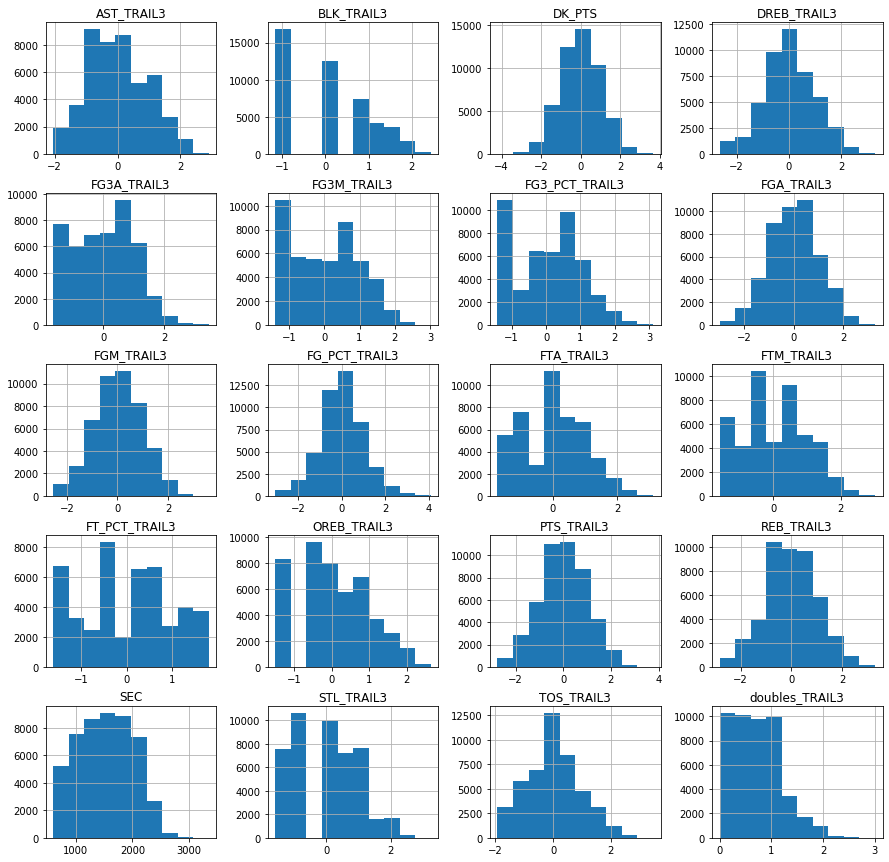

In [310]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
stats_sub_transform[vars_of_interest].hist(ax = ax);

In [311]:
lm_attempt1 = stats_sub_transform[vars_of_interest]
import statsmodels.api as sm
from statsmodels.formula.api import ols

outcome = 'DK_PTS'
predictors = lm_attempt1.drop('DK_PTS', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [312]:
model = ols(formula= formula, data=lm_attempt1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DK_PTS   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     4021.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        13:13:32   Log-Likelihood:                -43334.
No. Observations:               46505   AIC:                         8.671e+04
Df Residuals:                   46485   BIC:                         8.688e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.9744      0.014   -142.553      0.000      -2.002      -1.947
FGM_TRAIL3         0.1069      0.034      3.168      0.002       0.041       0.173
FGA_TRAIL3        -0.0043      0.015     -0.277      0.782      -0.035       0.026
FG_PCT_TRAIL3     -0.0311      0.006     -5.271      0.000      -0.043      -0.020
FG3M_TRAIL3        0.0107      0.014      0.750      0.453      -0.017       0.039
FG3A_TRAIL3       -0.0904      0.010     -8.725      0.000      -0.111      -0.070
FG3_PCT_TRAIL3    -0.0573      0.006     -9.096      0.000      -0.070      -0.045
FTM_TRAIL3         0.0796      0.018      4.403      0.000       0.044       0.115
FTA_TRAIL3         0.0222      0.012      1.853      0.064      -0.001       0.046
FT_PCT_TRAIL3     -0.0472      0.006     -7.425      0.000      -0.060      -0.035
OREB_TRAIL3        0.0690      0.010      6.695      0.000       0.049       0.089
DREB_TRAIL3        0.1965      0.024      8.076      0.000       0.149       0.244
REB_TRAIL3        -0.1737      0.030     -5.733      0.000      -0.233      -0.114
PTS_TRAIL3         0.0146      0.042      0.347      0.728      -0.068       0.097
STL_TRAIL3        -0.0266      0.003     -8.323      0.000      -0.033      -0.020
AST_TRAIL3         0.0562      0.004     14.509      0.000       0.049       0.064
BLK_TRAIL3         0.0256      0.003      7.880      0.000       0.019       0.032
TOS_TRAIL3         0.0533      0.004     13.872      0.000       0.046       0.061
doubles_TRAIL3     0.1162      0.011     10.428      0.000       0.094       0.138
SEC                0.0012   7.74e-06    160.739      0.000       0.001       0.001
==============================================================================
Omnibus:                      515.224   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              548.890
Skew:                          -0.237   Prob(JB):                    6.46e-120
Kurtosis:                       3.240   Cond. No.                     3.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

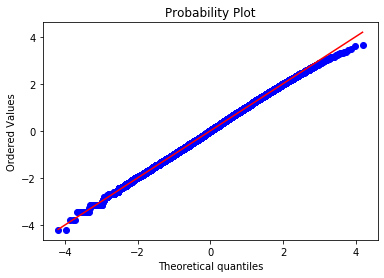

In [282]:
import scipy.stats as stats
import pylab
stats.probplot(stats_sub_transform['DK_PTS'], dist='norm', plot = pylab)
pylab.show()

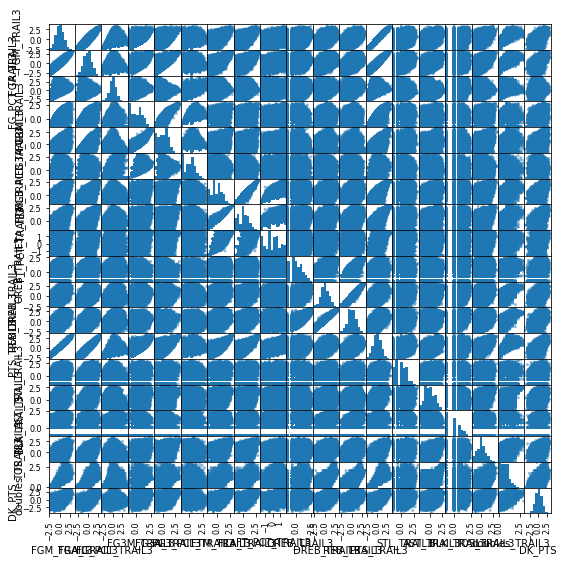

In [292]:
data = stats_sub_transform[vars_of_interest]
pd.plotting.scatter_matrix(data,figsize  = [9, 9]);
plt.show()

In [313]:
corr_matrix = stats_sub_transform[vars_of_interest].corr()

In [314]:
corr_matrix

,FGM_TRAIL3,FGA_TRAIL3,FG_PCT_TRAIL3,FG3M_TRAIL3,FG3A_TRAIL3,FG3_PCT_TRAIL3,FTM_TRAIL3,FTA_TRAIL3,FT_PCT_TRAIL3,OREB_TRAIL3,DREB_TRAIL3,REB_TRAIL3,PTS_TRAIL3,STL_TRAIL3,AST_TRAIL3,BLK_TRAIL3,TOS_TRAIL3,doubles_TRAIL3,SEC,DK_PTS
FGM_TRAIL3,1.000000,0.920738,0.481128,0.474247,0.448446,0.313187,0.606166,0.611472,0.522840,0.300093,0.533751,0.525077,0.976142,0.355923,0.515088,0.227600,0.558808,0.813729,0.574497,0.568559
FGA_TRAIL3,0.920738,1.000000,0.166163,0.542987,0.614388,0.308224,0.616327,0.608777,0.535847,0.222267,0.491608,0.465061,0.926791,0.386331,0.579230,0.162120,0.590799,0.754518,0.613821,0.574530
FG_PCT_TRAIL3,0.481128,0.166163,1.000000,0.021361,-0.163953,0.146047,0.184344,0.213449,0.165701,0.290749,0.299883,0.339383,0.422637,0.084685,0.063860,0.225128,0.139300,0.352426,0.110685,0.166202
FG3M_TRAIL3,0.474247,0.542987,0.021361,1.000000,0.903563,0.826224,0.213786,0.162550,0.231113,-0.235488,0.074083,-0.020957,0.557978,0.212540,0.317872,-0.116038,0.233249,0.315045,0.366262,0.209020
FG3A_TRAIL3,0.448446,0.614388,-0.163953,0.903563,1.000000,0.615406,0.249986,0.195441,0.258622,-0.254352,0.077353,-0.025507,0.531357,0.244726,0.366941,-0.127965,0.273425,0.295007,0.401484,0.239733
FG3_PCT_TRAIL3,0.313187,0.308224,0.146047,0.826224,0.615406,1.000000,0.091692,0.046929,0.125400,-0.225651,0.002657,-0.075838,0.379105,0.137234,0.208836,-0.122220,0.121428,0.185452,0.218129,0.082678
FTM_TRAIL3,0.606166,0.616327,0.184344,0.213786,0.249986,0.091692,1.000000,0.963077,0.868517,0.252997,0.427407,0.422849,0.720620,0.265601,0.406718,0.188877,0.468111,0.624150,0.416994,0.462392
FTA_TRAIL3,0.611472,0.608777,0.213449,0.162550,0.195441,0.046929,0.963077,1.000000,0.786708,0.304496,0.459101,0.465771,0.710165,0.269211,0.397672,0.225600,0.477556,0.636132,0.414375,0.472956
FT_PCT_TRAIL3,0.522840,0.535847,0.165701,0.231113,0.258622,0.125400,0.868517,0.786708,1.000000,0.183737,0.342520,0.333080,0.623070,0.224359,0.348371,0.131502,0.381490,0.518268,0.355703,0.372615
OREB_TRAIL3,0.300093,0.222267,0.290749,-0.235488,-0.254352,-0.225651,0.252997,0.304496,0.183737,1.000000,0.496928,0.718470,0.258264,0.099338,0.023063,0.371511,0.189339,0.398559,0.152459,0.253053


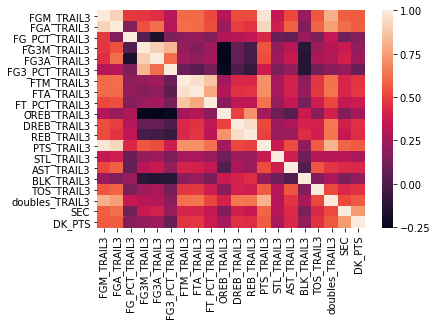

In [315]:
import seaborn as sns
sns.heatmap(corr_matrix)

In [316]:
corr_unstack = corr_matrix.unstack()
sorted_corr = corr_unstack.sort_values(kind="quicksort")

corr_df = pd.DataFrame(sorted_corr)
corr_df.columns = ['correlation']
# print(corr_df[(corr_df['correlation'].abs() > 0.3) & (corr_df['correlation'].abs() < 1)])
corr_df_index = corr_df.reset_index()
print(corr_df_index[corr_df_index['level_0'] == 'DK_PTS'].sort_values(by = 'correlation', ascending = False))

    level_0         level_1  correlation
399  DK_PTS          DK_PTS     1.000000
355  DK_PTS             SEC     0.742978
316  DK_PTS      FGA_TRAIL3     0.574530
312  DK_PTS      PTS_TRAIL3     0.573230
309  DK_PTS      FGM_TRAIL3     0.568559
306  DK_PTS  doubles_TRAIL3     0.559995
262  DK_PTS      FTA_TRAIL3     0.472956
252  DK_PTS      FTM_TRAIL3     0.462392
249  DK_PTS      TOS_TRAIL3     0.457417
246  DK_PTS     DREB_TRAIL3     0.455270
241  DK_PTS      REB_TRAIL3     0.442865
233  DK_PTS      AST_TRAIL3     0.423064
198  DK_PTS   FT_PCT_TRAIL3     0.372615
140  DK_PTS      STL_TRAIL3     0.269183
133  DK_PTS     OREB_TRAIL3     0.253053
125  DK_PTS     FG3A_TRAIL3     0.239733
95   DK_PTS      BLK_TRAIL3     0.212376
92   DK_PTS     FG3M_TRAIL3     0.209020
75   DK_PTS   FG_PCT_TRAIL3     0.166202
37   DK_PTS  FG3_PCT_TRAIL3     0.082678


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


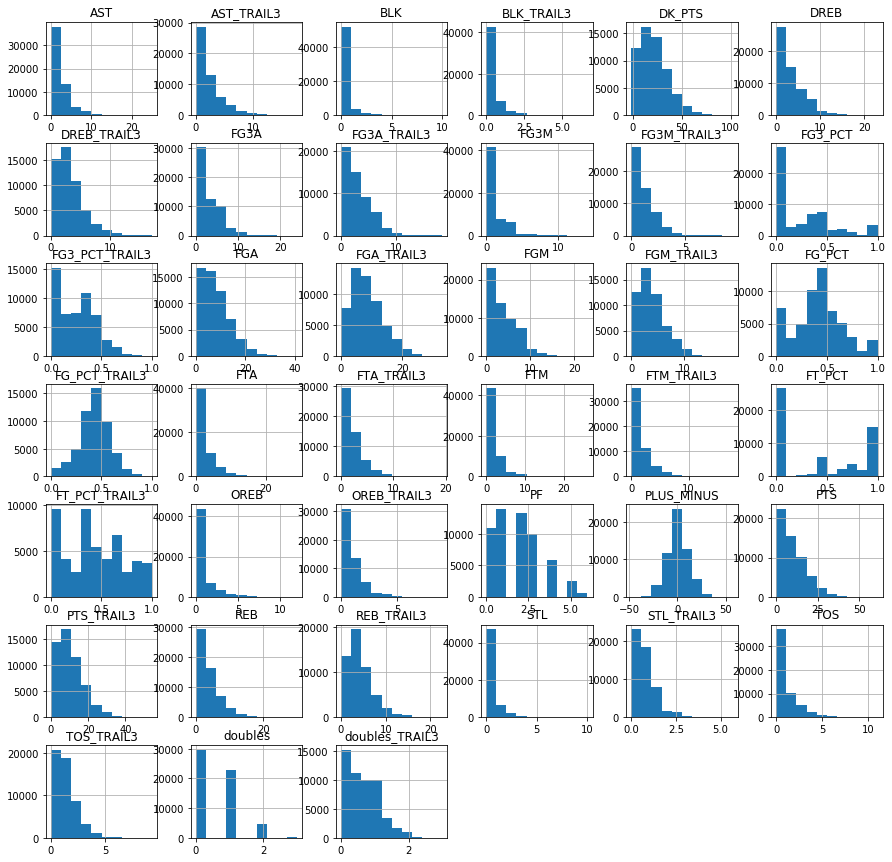

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
stats_sub.hist(ax = ax);

# Get Trailing Averages for Last 5 Games